In [197]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

# Principal Component Analysis
from sklearn.decomposition import PCA

# Auxillary functions

In [237]:
def load_data(path:str, as_df=True):
    """Given the path of the directory containing the data, 
    the respective mat_file and M_curves data is loaded"""
    mat_file = "echo_params.txt"
    M_file_r = "echos_r" # real part of echos
    M_file_i = "echos_i" # imaginary part of echos

    mat_info = np.loadtxt(os.path.join(path,mat_file));

    # M(t) curve for each simulation:
    M_r = np.loadtxt(os.path.join(path,M_file_r));
    M_i = np.loadtxt(os.path.join(path,M_file_i));
    print("Finished loading data into numpy array")
    return np.abs(M_r + 1j*M_i)

def load_params(path:str):
    """Given the directory path loads the input parameter files for the simualtions"""
    params = np.loadtxt(os.path.join(path,"echo_params.txt"))
    cols = 'αx αy αz ξ p Γ3 stencil_type s p d pulse90 pulse180'.split()
    print("Finsihed loading parameters file")
    return pd.DataFrame(params,columns=cols)

def get_window(data:np.ndarray, center_ratio:float, width:float):
    """Returns a subset of the given array with only those datapoints between 
    [center - width , center + width] for all rows/examples"""
    start = int((center_ratio)*data.shape[1])
    return data[:,start-width:start+width], start

def standard_scale(data:np.ndarray):
    """Standardizing the given array with mean=0 and variance=1 column-wise"""
    mean,std = np.mean(data,axis=0), np.std(data,axis=0)
    return (data-mean)/std

def normalize_minmax(data:np.ndarray):
    """Normalizing the data so that all values are within the new range of 0 and 1"""
    return (data - np.min(data,axis=0))/(np.max(data,axis=0) - np.min(data,axis=0))

def pca1D(data:np.ndarray):
    """Returns a 1D PCA version of the given dataset. 
    The given dataset (input) should already be normalised. 
    Returns: 
        Dim-reduced 1D data, variance explained by the one dimension"""
    pca2D = PCA(n_components=1)
    pca2D_data = pca2D.fit_transform(data)
    variance = pca2D.explained_variance_ratio_
    principal_data = pd.DataFrame(data = pca2D_data, columns = ['PC1'])
    return principal_data, variance
    
def pca2D(data:np.ndarray):
    """Returns a 2D PCA version of the given dataset. 
    The given dataset (input) should already be normalised. 
    Returns: 
        Dim-reduced 2D data, variance explained by the two dimensions"""
    pca2D = PCA(n_components=2)
    pca2D_data = pca2D.fit_transform(data)
    variance = pca2D.explained_variance_ratio_
    principal_data = pd.DataFrame(data = pca2D_data, columns = ['PC1', 'PC2'])
    return principal_data, variance

def pca3D(data:np.ndarray):
    """Returns a 3D PCA version of the given dataset. 
    The given dataset (input) should already be normalised. 
    Returns: 
        Dim-reduced 3D data, variance explained by the two dimensions"""
    pca2D = PCA(n_components=3)
    pca2D_data = pca2D.fit_transform(data)
    variance = pca2D.explained_variance_ratio_
    principal_data = pd.DataFrame(data = pca2D_data, columns = ['PC1', 'PC2','PC3'])
    return principal_data, variance

def get_random_points(start,end,no_points):
    """Generates 'no_points' random points between (start, end)"""
    np.random.seed(1)
    data = np.arange(start,end,1)
    np.random.shuffle(data)
    return data[:no_points]

def plot_cumvar_pca(data,title):
    """Plots the cumulative variance explained by PCA for different 
    number of components"""
    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
    pca = PCA().fit(data)

    axes[0,0].plot(np.cumsum(pca.explained_variance_ratio_),'bx',alpha=0.6)
    axes[0,1].plot(np.cumsum(pca.explained_variance_ratio_)[:200],'bx',alpha=0.6)
    axes[1,0].plot(np.cumsum(pca.explained_variance_ratio_)[:50],'bx',alpha=0.6)
    axes[1,1].plot(np.cumsum(pca.explained_variance_ratio_)[:10],'bx',markersize=8,alpha=0.6)

    for _,ax in np.ndenumerate(axes):
        ax.set_xlabel('Number of Principal components')
    plt.suptitle(f'Cumulative Variance Expalined by PCA ({title})',fontsize=20)
    return axes

# Import Data

In [199]:
path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-13_classify_datagen_no_dissipation"


In [200]:
M = load_data(path,as_df=True)
offset = 150
M, center = get_window(M,2/3,offset)

Finished loading data into numpy array


# EDA on parameters file

In [201]:
params = load_params(path)
print(params.columns)

Finsihed loading parameters file
Index(['αx', 'αy', 'αz', 'ξ', 'p', 'Γ3', 'stencil_type', 's', 'p', 'd',
       'pulse90', 'pulse180'],
      dtype='object')


In [202]:
params.tail()

,αx,αy,αz,ξ,p,Γ3,stencil_type,s,p,d,pulse90,pulse180
9995,0.005961,0.005961,0.000849,0.000000,3.750553,0.0,1.0,1.0,0.0,0.0,1.570796,3.141593
9996,0.006068,0.006068,0.002739,0.000000,3.982249,0.0,1.0,1.0,0.0,0.0,1.570796,3.141593
9997,0.001940,0.001940,0.010209,0.000000,3.794058,0.0,1.0,1.0,0.0,0.0,1.570796,3.141593
9998,0.004899,0.004899,0.000412,0.000000,3.471265,0.0,1.0,1.0,0.0,0.0,1.570796,3.141593
9999,0.006785,0.006785,0.012084,1.218983,2.000000,0.0,0.0,1.0,0.0,0.0,1.570796,3.141593


In [203]:
params['stencil_type'].value_counts()/len(params)

1.0    0.8812
0.0    0.1188
Name: stencil_type, dtype: float64

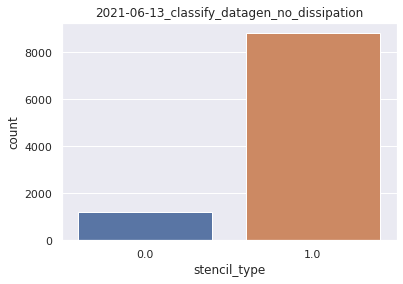

In [204]:
plt.title("2021-06-13_classify_datagen_no_dissipation")
sns.countplot(x=params.stencil_type)
plt.show()

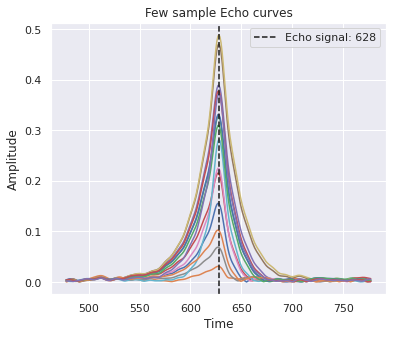

In [74]:
# Plotting a few curves

fig = plt.figure(figsize=(6,5))
for i in range(15):
    plt.plot(range(center-offset,center+offset),M[100*i,:])
plt.axvline(center,color='k',linestyle='--',label=f'Echo signal: {center}')
plt.legend()
plt.title('Few sample Echo curves')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Data Preprocessing

In [205]:
# Normalize data and plot curves

norm_data = normalize(M)
std_data = standard_scale(M) # normalizing the features

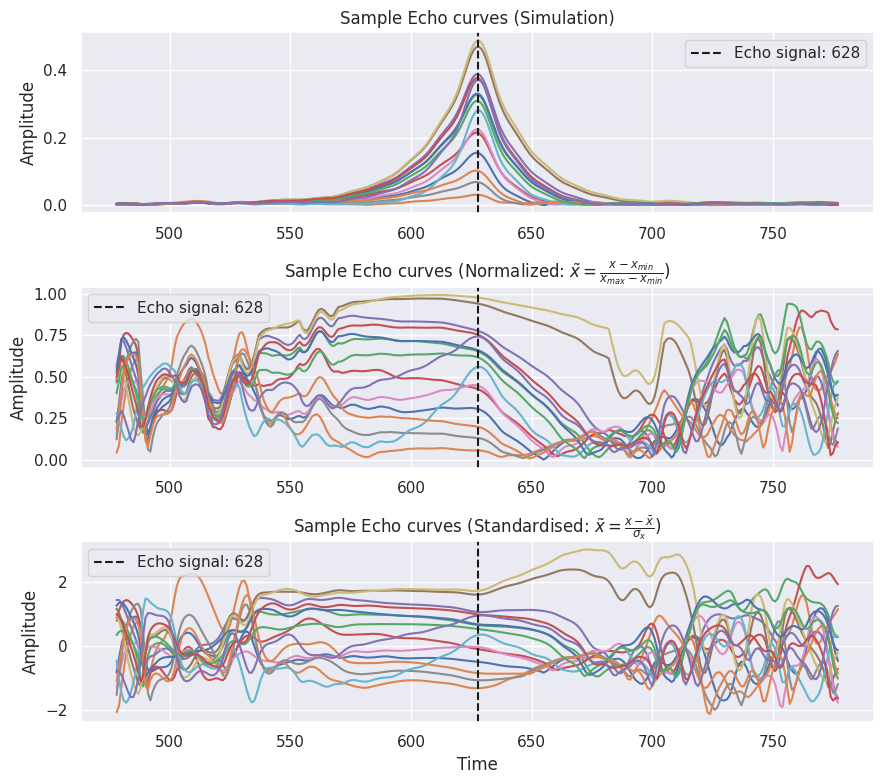

In [229]:
fig,ax = plt.subplots(3,1,figsize=(9,8),dpi=100)
curves=['Simulation',
        'Normalized: '+r'$\tilde{x} = \frac{x-x_{min}}{x_{max}-x_{min}}$',
        'Standardised: '+r'$\tilde{x} = \frac{x-\bar{x}}{\sigma _x}$']
for i in range(15):
    ax[0].plot(range(center-offset,center+offset),M[100*i,:])
    ax[1].plot(range(center-offset,center+offset),norm_data[100*i,:])
    ax[2].plot(range(center-offset,center+offset),std_data[100*i,:])
    
for i in (0,1,2):
    ax[i].axvline(center,color='k',linestyle='--',label=f'Echo signal: {center}')
    ax[i].set_title(f'Sample Echo curves ({curves[i]})')
    ax[i].set_ylabel('Amplitude')
    ax[i].legend()

plt.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

## KDE-plot distribution of various features

In [145]:
# convert the features into a tabular format
feat_cols = ['feature'+str(i) for i in range(M.shape[1])]
normalised_data = pd.DataFrame(norm_data,columns=feat_cols)
given_data = pd.DataFrame(M,columns=feat_cols)
normalised_data.tail()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,...,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299
9995,-0.654818,-1.223532,-1.629626,-1.865910,-1.946329,-1.898849,-1.758654,-1.545658,-1.270320,-0.914755,-0.369583,0.437093,1.006353,1.148275,1.159178,1.157304,1.142063,1.126771,1.120692,1.117910,1.108843,1.076235,0.995808,0.830961,0.550171,0.188482,-0.146160,-0.383688,-0.526697,-0.601268,-0.628485,-0.621641,-0.592273,-0.555892,-0.530653,-0.528748,-0.550152,-0.585409,-0.622717,-0.651873,...,0.664325,0.393463,0.029344,-0.313374,-0.524502,-0.599985,-0.585235,-0.497321,-0.321522,-0.065741,0.209717,0.389676,0.393436,0.218452,-0.099608,-0.483167,-0.778174,-0.818406,-0.658398,-0.489440,-0.421647,-0.464741,-0.561774,-0.670378,-0.784478,-0.922413,-1.097171,-1.277738,-1.405314,-1.482158,-1.564368,-1.665676,-1.434193,-1.008414,-0.539212,-0.087487,0.318223,0.624092,0.781284,0.771337
9996,-0.150941,-0.728372,-1.157133,-1.363861,-1.355930,-1.225151,-1.073170,-0.953425,-0.878460,-0.836311,-0.744741,-0.414413,0.037434,0.249432,0.265190,0.200616,0.118922,0.040493,-0.031120,-0.096229,-0.156581,-0.211368,-0.259170,-0.294754,-0.305906,-0.283572,-0.240552,-0.199991,-0.174564,-0.167284,-0.177617,-0.203308,-0.239490,-0.278733,-0.313394,-0.338906,-0.355287,-0.367108,-0.381499,-0.405050,...,0.485519,0.301234,0.005273,-0.326057,-0.580464,-0.698202,-0.669683,-0.508602,-0.246895,0.054538,0.311344,0.423759,0.351235,0.116981,-0.244522,-0.687732,-1.122585,-1.377674,-1.304577,-1.089109,-0.939294,-0.874801,-0.790767,-0.606796,-0.295185,0.132980,0.615919,1.027855,1.253929,1.298079,1.220062,1.044494,0.774860,0.408363,-0.073566,-0.710268,-1.460915,-1.597903,-1.278853,-1.079261
9997,-1.866210,-1.403333,-0.803288,-0.262535,0.186259,0.534768,0.787445,0.962429,1.071176,1.094343,0.903666,0.199456,-0.807332,-1.667512,-1.515374,-1.190583,-0.969032,-0.825457,-0.747076,-0.700375,-0.651721,-0.563876,-0.400680,-0.127555,0.257880,0.673633,1.003374,1.214937,1.342755,1.421710,1.467840,1.481606,1.455522,1.384803,1.274953,1.137836,0.984669,0.823803,0.659785,0.492405,...,-1.543737,-1.351526,-1.136928,-0.953681,-0.834470,-0.762683,-0.690405,-0.571405,-0.381321,-0.130314,0.158832,0.442828,0.686962,0.880255,0.988146,0.942777,0.693852,0.283388,-0.134840,-0.360601,-0.331580,-0.140018,0.132996,0.389748,0.531044,0.487696,0.227768,-0.210667,-0.698407,-1.123873,-1.448887,-1.573163,-1.404674,-1.179576,-0.965471,-0.777066,-0.585923,-0.379843,-0.161130,0.060882
9998,-1.914400,-2.213191,-2.204446,-2.172435,-2.204870,-2.274041,-2.041068,-1.686836,-1.323973,-0.925091,-0.380291,0.378185,0.895507,1.010106,0.999390,0.981093,0.966189,0.964194,0.974820,0.984361,0.976635,0.929043,0.812117,0.587393,0.234182,-0.184959,-0.542877,-0.776190,-0.901443,-0.952281,-0.951352,-0.911090,-0.843152,-0.766677,-0.706107,-0.678446,-0.683908,-0.708946,-0.735500,-0.746926,...,-0.021692,-0.304622,-0.590678,-0.737320,-0.722265,-0.655561,-0.618722,-0.621176,-0.618620,-0.553671,-0.410144,-0.264690,-0.223159,-0.322409,-0.534422,-0.769932,-0.874229,-0.765731,-0.574049,-0.438858,-0.418883,-0.506364,-0.631935,-0.737143,-0.809348,-0.875818,-0.971068,-1.091724,-1.189461,-1.226834,-1.179006,-1.017589,-0.740005,-0.371202,0.037445,0.439351,0.801409,1.072841,1.215108,1.218868
9999,1.225798,1.382814,1.527301,1.65

In [128]:
features = ['feature'+ str(i) for i in np.arange(0,300,12)]
titles = ['Feature '+ str(int(i[7:]) + center-offset) for i in features]

In [ ]:
# Plot kdeplot (5x5) for every 12th feature
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(nrows=5,ncols=5,figsize=(13,11))

counter = 0
for idx,_ in np.ndenumerate(ax1):
    sns.kdeplot(ax=ax1[idx], x = given_data[features[counter]])
    ax1[idx].set(ylabel=' ',xlabel=' ',title=titles[counter])
    counter += 1

plt.suptitle(f"KDE plots for Given Data (Echo Pulse : Feature{center})",fontsize=18,y=0.98)
plt.tight_layout()

In [ ]:
# Plot kdeplot (5x5) for every 12th feature
fig1, ax1 = plt.subplots(nrows=5,ncols=5,figsize=(13,11))

counter = 0
for idx,_ in np.ndenumerate(ax1):
    sns.kdeplot(ax=ax1[idx], x = normalised_data[features[counter]])
    ax1[idx].set(ylabel=' ',xlabel=' ',title=titles[counter])
    counter += 1

plt.suptitle(f"KDE plots for Normalized Data (Echo Pulse : Feature{center}",fontsize=18)
plt.tight_layout()

# PCA

## Variance vs no of components

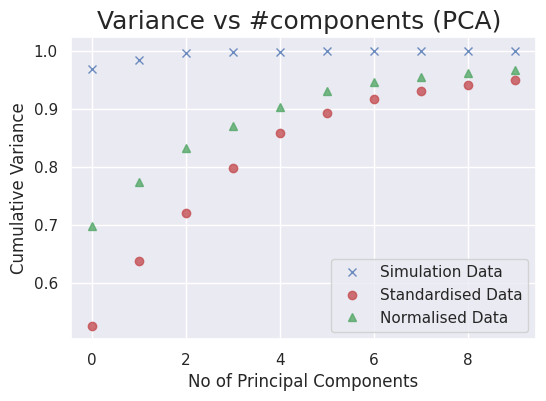

In [408]:
pca_M = PCA().fit(M)
pca_s = PCA().fit(std_data)
pca_n = PCA().fit(norm_data)

fig = plt.figure(dpi=100)
plt.title("Variance vs #components (PCA) ",fontsize=18)
plt.plot(np.cumsum(pca_M.explained_variance_ratio_)[:10],'bx',alpha=0.8,label='Simulation Data')
plt.plot(np.cumsum(pca_s.explained_variance_ratio_)[:10],'ro',alpha=0.8,label='Standardised Data')
plt.plot(np.cumsum(pca_n.explained_variance_ratio_)[:10],'g^',alpha=0.8,label='Normalised Data')
plt.xlabel('No of Principal Components')
plt.ylabel('Cumulative Variance')
plt.legend()
plt.show()

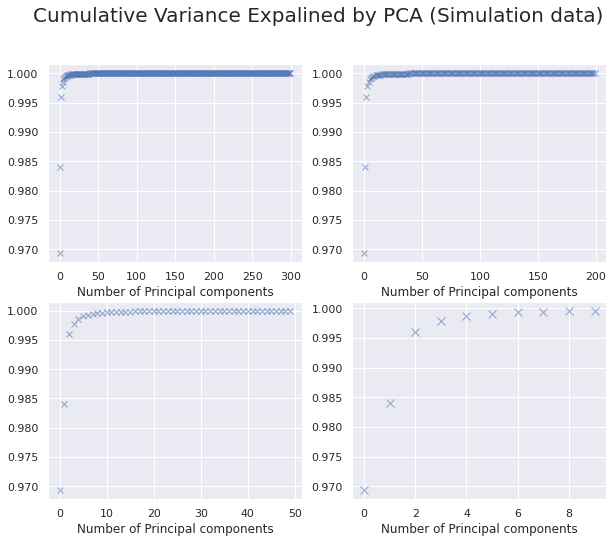

In [235]:
# Choosing the number of components

plot_cumvar_pca(M,"Simulation data")
plt.show()

## PCA Simulation data (1D)

In [246]:
pca_1d, pca1d_varaince = pca1D(M)

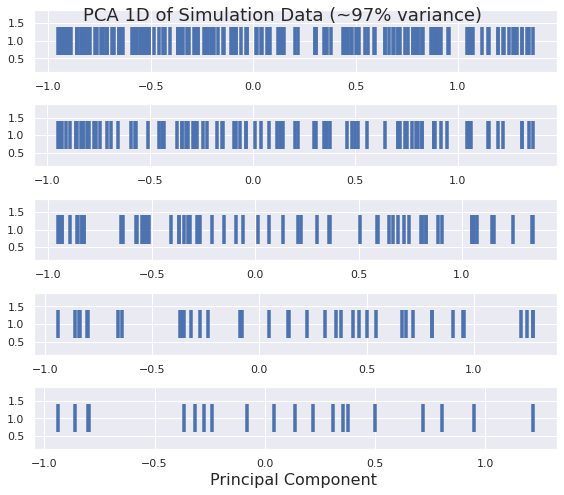

In [307]:
fig,axes = plt.subplots(5,1,figsize=(8,7))
bin = [50,100,150,250,500]
for i,ax in np.ndenumerate(axes):
    ax.eventplot(pca_1d.PC1[range(0,10_000,bin[i[0]])].values,linelengths = 0.8,linewidths=3.5)

plt.suptitle("PCA 1D of Simulation Data (~97% variance)",fontsize=18)
plt.xlabel('Principal Component ',fontsize=16)
plt.tight_layout()

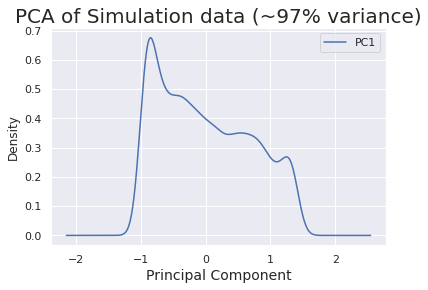

In [311]:
pca_1d[:].plot.kde()
plt.title("PCA of Simulation data (~97% variance)",fontsize=20)
plt.xlabel("Principal Component",fontsize=14)
plt.show()

## PCA 2D

In [312]:
pca_2d, pca_2d_explained_ratio = pca2D(M)

In [313]:
pca_normdata2d, pca_normdata2d_explained_ratio = pca2D(norm_data)

In [314]:
pca_stddata2d, pca_stddata2d_explained_ratio = pca2D(std_data)

In [315]:
print('Explained variation per principal component for Simulation Data: {}'.format(pca_2d_explained_ratio))
print('Explained variation per principal component for Normalised Data: {}'.format(pca_normdata2d_explained_ratio))
print('Explained variation per principal component for Standardised Data: {}'.format(pca_stddata2d_explained_ratio))

Explained variation per principal component for Simulation Data: [0.96932638 0.01467335]
Explained variation per principal component for Normalised Data: [0.69833929 0.07559865]
Explained variation per principal component for Standardised Data: [0.52695794 0.11128658]


## PCA plots (2D)

In [348]:
def plot_pca2d(df,exp_var,title):
    """Plots the PCA 2D subplots for different number of points for the 
    given PCA dataframe, explained varaince by the two principal components and title of the plot. 
    Returns a axes object that can be directly plotted"""

    idx = lambda binsize : range(0,len(df),binsize)
    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

    npoints = [1,10,30,70]
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.suptitle(f"PCA (~{exp_var}% variance) of Magnetization curves ({title})",fontsize=20)

    counter=0
    for _,ax in np.ndenumerate(axes):
        ax.set_xlabel('Principal Component-1')
        ax.set_ylabel('Principal Component-2')
        ax.plot(df.PC1[idx(npoints[counter])],
                df.PC2[idx(npoints[counter])],'bx',markersize=2+counter, alpha=0.6+counter/19,
                label=f"{len(idx(npoints[counter]))} points")
        ax.legend(loc='upper right')
        counter+=1
    
    return axes

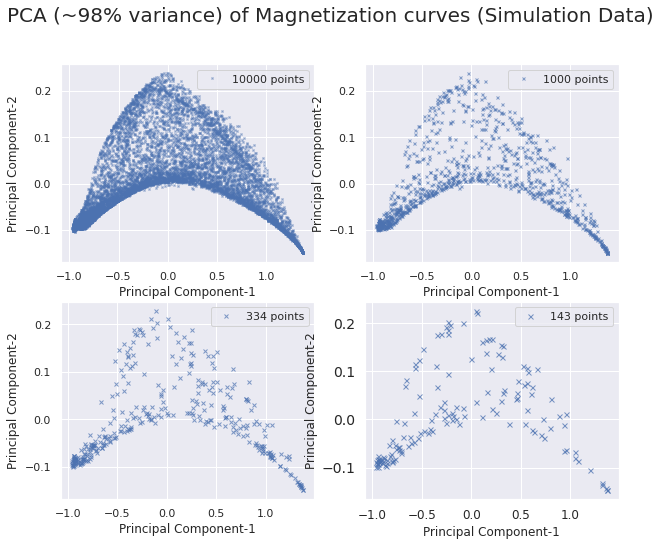

In [349]:
plot_pca2d(pca_2d,98,"Simulation Data")
plt.show()

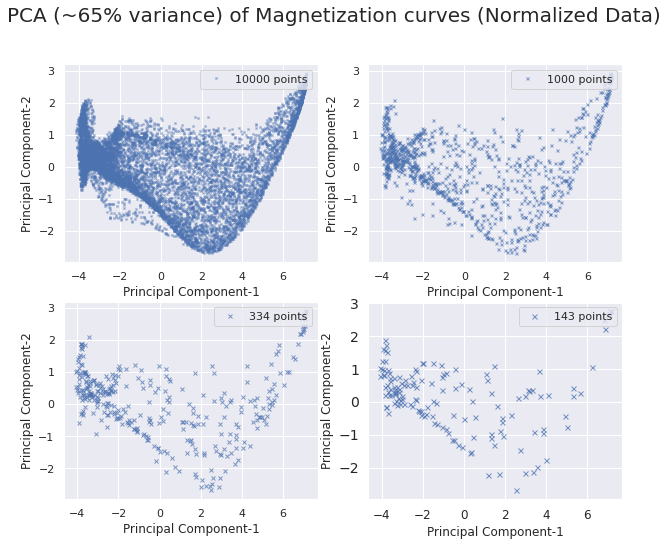

In [350]:
plot_pca2d(pca_normdata2d,65,"Normalized Data")
plt.show()

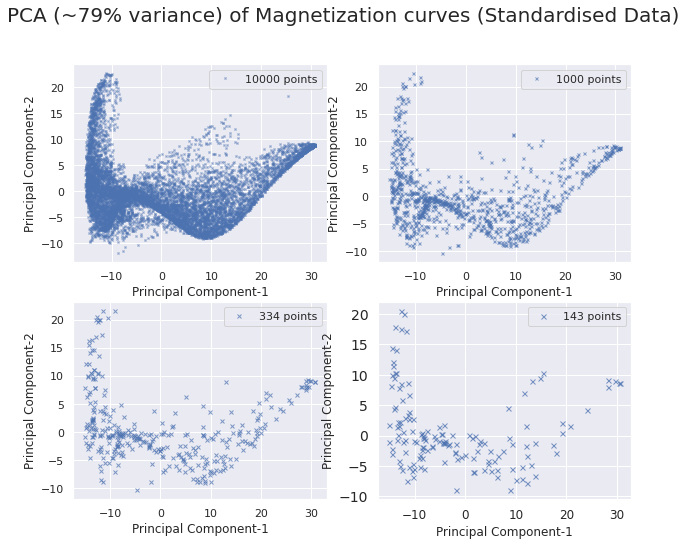

In [351]:
plot_pca2d(pca_stddata2d,79,"Standardised Data")
plt.show()

## PCA (3D)

In [411]:
pca_3d, pca_3d_explained_ratio = pca3D(M)
pca_normdata3d, pca_normdata3d_explained_ratio = pca3D(norm_data)
pca_stddata3d, pca_stddata3d_explained_ratio = pca3D(std_data)

In [353]:
print('Explained variation per principal component for Simulation Data: {}'.format(pca_3d_explained_ratio))
print('Explained variation per principal component for Normalised Data: {}'.format(pca_normdata3d_explained_ratio))
print('Explained variation per principal component for Standardised Data: {}'.format(pca_stddata3d_explained_ratio))

Explained variation per principal component for Simulation Data: [0.96932638 0.01467335 0.01205779]
Explained variation per principal component for Normalised Data: [0.69833929 0.07559865 0.05876532]
Explained variation per principal component for Standardised Data: [0.52695794 0.11128658 0.08271662]


In [427]:
def plot_pca3d(df,exp_var,title):
    """Plots the PCA 3D subplots for different number of points for the 
    given PCA dataframe, explained varaince by the two principal components and title of the plot. 
    Returns a axes object that can be directly plotted"""    

    idx = lambda binsize : range(0,len(df),binsize)
    npoints = [1,10,30,70]
    counter=0
    fig = plt.figure(figsize=(10, 7))
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
        ax.plot3D(df.PC1[idx(npoints[counter])], df.PC2[idx(npoints[counter])], 
             df.PC3[idx(npoints[counter])], 'g^',
             markersize=2+counter, alpha=0.4+counter/19,
            label=f"{len(idx(npoints[counter]))} points")
        
        ax.legend(loc='upper right')
        counter+=1

    plt.suptitle(f"PCA (~{exp_var}% variance) of Magnetization curves ({title})",fontsize=20)
    return axes

def plot_pca3d_in2d(df,exp_var,title):
    """Plots the PCA 2D subplots for different number of points for the 
    given PCA dataframe, explained varaince by the two principal components and title of the plot. 
    The color of 2D plots represents the 3rd component color 
    Returns a axes object that can be directly plotted"""    

    idx = lambda binsize : range(0,len(df),binsize)
    fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

    npoints = [1,10,30,70]
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.suptitle(f"PCA (~{exp_var}% variance) of Magnetization curves ({title})",fontsize=20)

    counter=0
    for _,ax in np.ndenumerate(axes):
        ax.set_xlabel('Principal Component-1')
        ax.set_ylabel('Principal Component-2')
        ax.scatter(df.PC1[idx(npoints[counter])],
                df.PC2[idx(npoints[counter])],c = df.PC3[idx(npoints[counter])], 
                alpha=0.6+counter/19,
                label=f"{len(idx(npoints[counter]))} points")
        ax.legend(loc='upper right')
        counter+=1
    return axes

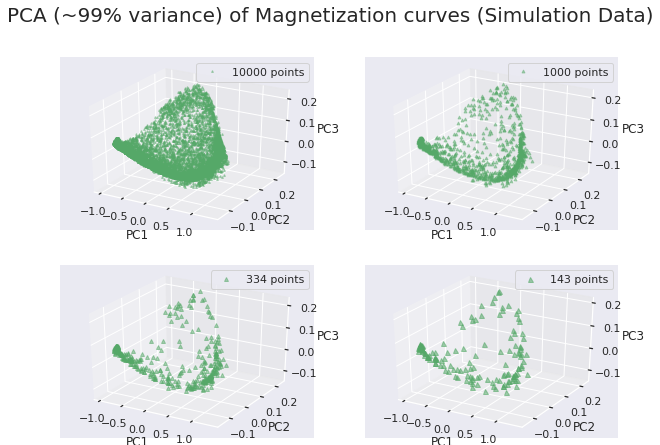

In [418]:
plot_pca3d(pca_3d,99,"Simulation Data")
plt.show()

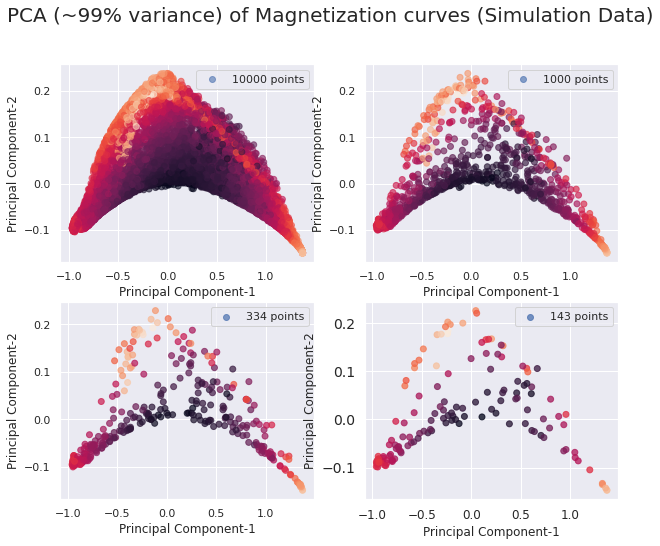

In [429]:
plot_pca3d_in2d(pca_3d,99,"Simulation Data")
plt.show()

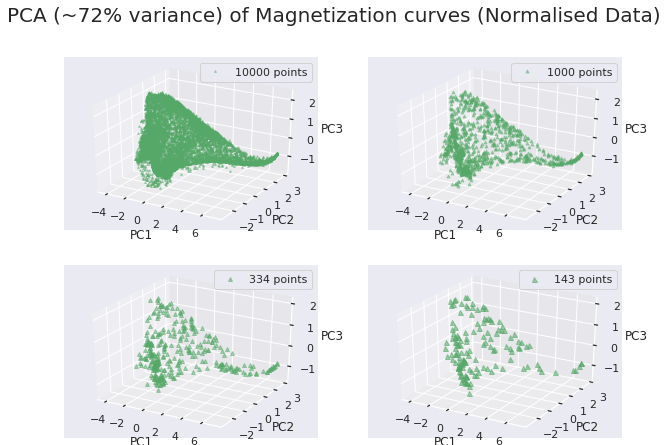

In [409]:
plot_pca3d(pca_normdata3d,72,"Normalised Data")
plt.show()

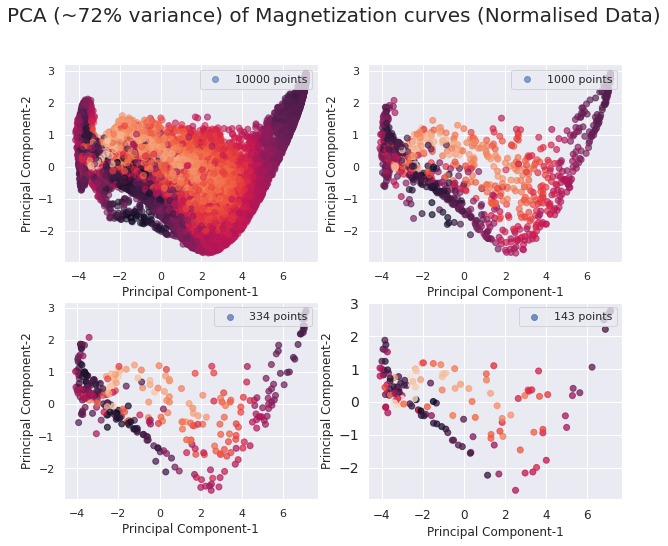

In [430]:
plot_pca3d_in2d(pca_normdata3d,72,"Normalised Data")
plt.show()

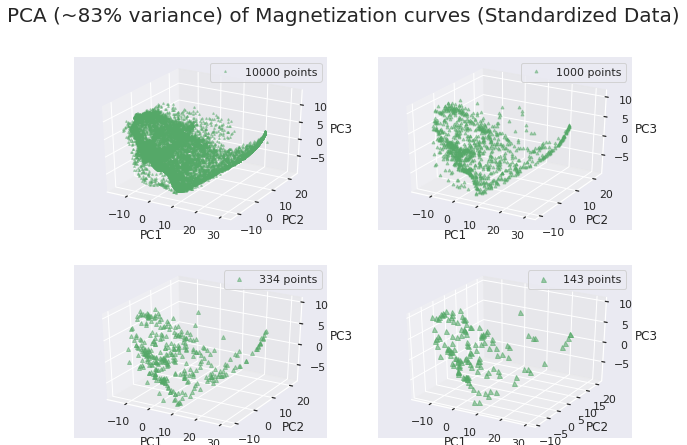

In [412]:
plot_pca3d(pca_stddata3d,83,"Standardized Data")
plt.show()

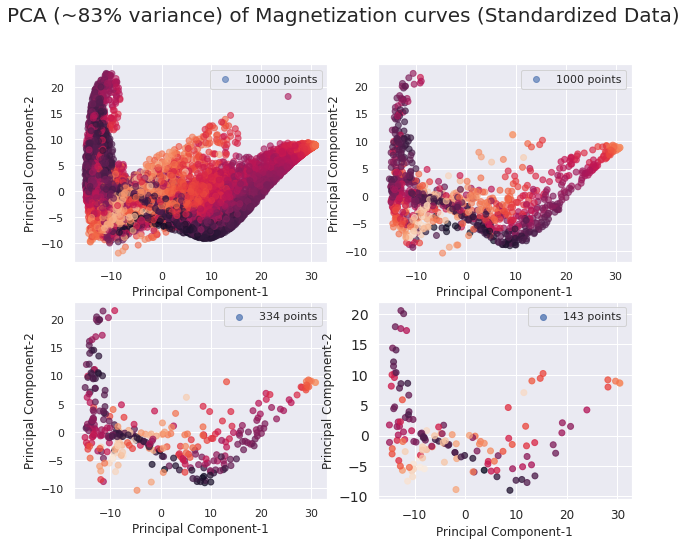

In [431]:
plot_pca3d_in2d(pca_stddata3d,83,"Standardized Data")
plt.show()